In [1]:
'''Import'''
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import pandas as pd
import xarray as xr
from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction

import time 
import seaborn as sns
from itertools import product
from scipy.interpolate import interp2d
from bayes_opt.logger import JSONLogger
from bayes_opt.event import Events
from bayes_opt.util import load_logs

from scipy.interpolate import NearestNDInterpolator

from clmmodtools import *
import shutil

#ML
from sklearn.gaussian_process import GaussianProcessRegressor 

In [2]:
def blackbox_clm_wte(baseflow, fmax, slopebeta, fff,conifslope, decidslope, grassslope):
    #change parameter in netcdf file
    target_surface_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_lagg_pftdist_soildepth.nc'
    target_param_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/clm50_params_medlynslope_bayesopt.c240105.nc'
    target_param1 = 'baseflow_scalar'
    target_param2 = 'FMAX' 
    target_param3 = 'slopebeta'
    target_param4 = 'fff'
    target_param5 = 'medlynslope'
    base_grass_ms = 5.25
    base_conif_ms = 2.3499999
    base_decid_ms = 4.44999981

    #change grass parameters 
    change_pft_param(target_param5, 13, grassslope*base_grass_ms, target_param_file)

    #change tree parameters
    change_pft_param(target_param5, 2, conifslope*base_conif_ms, target_param_file) #conif
    change_pft_param(target_param5, 8, decidslope*base_decid_ms, target_param_file) #decid
    
    #change surface parameters
    change_surf_param(target_param2, fmax, 0, target_surface_file)

    #change param file
    change_param(target_param3, slopebeta, target_param_file)
    change_param(target_param4, fff, target_param_file)
    
    os.chdir(CASE_DIR)
    
    #change namelist parameters
    change_nl_param(target_param1, baseflow)

    #run case
    pipe = subprocess.Popen(['./case.submit'], stdout=subprocess.PIPE)
    #result = pipe.communicate()[0]
    #print(result)
    #print(CASE_NAME + " Run Complete")
    
    #time delay -- check if archived data exists, if not wait 5 more seconds
    #Have to check for the column specific run here for proper bog wte calibration
    SCRATCH_DIR = '/glade/derecho/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/'
    while(not os.path.exists(SCRATCH_DIR + CASE_NAME + '.clm2.h3.2015-01-01-00000.nc')):
        time.sleep(5)
    
    #find WTE data in scracth directory
    os.chdir(SCRATCH_DIR)
    
    #Open data h1 and h3 data files
    coldata = xr.load_dataset(CASE_NAME + '.clm2.h3.2015-01-01-00000.nc')
    data = xr.load_dataset(CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')
    
    #Compute correlation metric
    spday = 86400
    data['ET'] = data.QVEGT + data.QSOIL
    observedWTE = np.array(wte_calib.WTD)
    modelWTE = -np.array(coldata.sel(column = 1).sel(time = slice("2015-01-01", "2015-12-31")).ZWT.values)
    observedQ = np.array(stream_calib.flow_mmday)
    modelQ = spday*np.array(data.sel(time = slice("2015-01-01", "2015-12-31")).QRUNOFF.values.ravel())
    observedET = np.array(flux_calib.OET)
    modelET = spday*np.array(data.sel(time = slice("2015-01-01", "2015-12-31")).ET.values.ravel())
    #Compound Lee Choi Efficiency
    LCE = calcCompoundLCE(observedWTE, modelWTE, observedQ, modelQ, observedET, modelET)
    
    #remove data
    os.remove(CASE_NAME + '.clm2.h3.2015-01-01-00000.nc')
    os.remove(CASE_NAME + '.clm2.h2.2015-01-01-00000.nc')
    
    #return efficiency metric
    return LCE

acquisition_function = UtilityFunction(kind = "ucb", kappa = 10e2)

In [8]:
'''Load Optimizer'''

clm_optimizer = BayesianOptimization(f = blackbox_clm_wte, 
                                    pbounds = {'baseflow': (0,10),
                                               'fmax': (0.1, 0.7), 
                                               'slopebeta' : (-10e2, 10), 
                                               'fff' : (0.1, 5), 
                                               'conifslope' : (1, 40), 
                                               'decidslope' : (1, 40), 
                                               'grassslope' : (1, 40)}, 
                                    random_state = 75832, 
                                    verbose = 0
                                    )

#logger object records optimization search
load_logs(clm_optimizer, logs=["/glade/u/home/marielj/clm_frost/clm-runscripts/logs/clm_logs_lce.json"])

ValueError: Parameters' keys (['baseflow', 'fff', 'fmax', 'grassslope', 'slopebeta']) do not match the expected set of keys (['baseflow', 'conifslope', 'decidslope', 'fff', 'fmax', 'grassslope', 'slopebeta']).

In [4]:
print("New optimizer is now aware of {} points.".format(len(clm_optimizer.space)))

New optimizer is now aware of 159 points.


Text(0, 0.5, 'LCE')

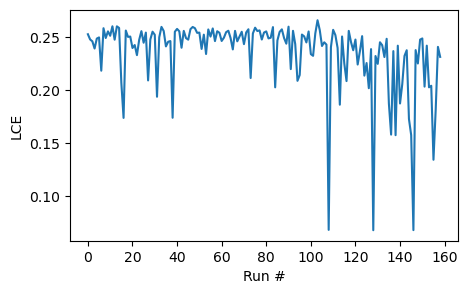

In [5]:
#R2 values - model fit
x = [res["target"] for res in clm_optimizer.res]

fig, ax = plt.subplots(1, 1, figsize = (5, 3))
ax.plot(x)
ax.set_xlabel('Run #')
ax.set_ylabel(r'LCE')

In [6]:
def plot_gp_2D(optimizer, aq, it, param1, param2, param1_min, param1_max, param2_min, param2_max):
    #Setup 
    #Breakdown Data
    max_ = optimizer.max
    res = optimizer.res[:it]
    x_ = np.array([r["params"][param1] for r in res])
    y_ = np.array([r["params"][param2] for r in res])
    z_ = np.array([r["target"] for r in res])

    #Model Results
    ser = pd.Series(z_, index=[y_, x_])
    Z = ser.unstack().fillna(np.nan)

    #Range space
    l1 = len(Z.columns) 
    l2 = len(Z.index)
    x1 = np.linspace(param1_min, param1_max, l1).reshape(-1, 1)
    x2 = np.linspace(param2_min, param2_max, l2).reshape(-1, 1)
    xmesh, ymesh = np.meshgrid(x1, x2)
    xy = np.array(list(zip(xmesh.reshape(l1*l2, 1), ymesh.reshape(l1*l2, 1)))).reshape(l1*l2,2)
    
    #Plot
    fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(6,6))

    #Axis 1: Function Estimate
    interp = NearestNDInterpolator(list(zip(x_, y_)), z_)
    mesh1 = axs.pcolormesh(Z.columns, Z.index, interp(xy).reshape(l2, l1), cmap=plt.cm.coolwarm)
    #mesh1 = axs.imshow(interpgrid, cmap=plt.cm.coolwarm, aspect = 'auto')
    axs.scatter(x_, y_, c='white', s=80, edgecolors='black')
    axs.scatter(x_, y_, c='red', s=80, edgecolors='black')
    axs.scatter(max_["params"][param1], max_["params"][param2], s=80, c='green', edgecolors='black')

    axs.set_title('Function Estimate')
    axs.set_xlabel(param1)
    axs.set_ylabel(param2)

    axs.set_xlim(param1_min, param1_max)
    axs.set_ylim(param2_min, param2_max)

    fig.colorbar(mesh1, location = 'bottom', label = "LCE")
    plt.show()

In [7]:
plot_gp_2D(clm_optimizer, acquisition_function, 150, 'baseflow', 'grassslope', 0.1, 5, 0.1, 0.7)

ValueError: Index contains duplicate entries, cannot reshape

In [ ]:
clm_optimizer.res[-1]

Plot iteration of hillslope

In [ ]:
'''Load calibration WTE data'''
calib_year = 2017
infile1  ="https://pasta.lternet.edu/package/data/eml/edi/562/2/671f15337a677da71852de506a8d9b05".strip() 
infile1  = infile1.replace("https://","http://")
                 
dt1 =pd.read_csv(infile1, skiprows = 1, sep = ",",
                 names=["PEATLAND", "DATE", "WTE", "FLAG"],
                 parse_dates=['DATE'], 
                 na_values={'WTE':['NA',], 'FLAG':['NA',]})

# Coerce the data into the types specified in theA metadata  
dt1.PEATLAND = dt1.PEATLAND.astype('category') 

dt1.WTE = pd.to_numeric(dt1.WTE, errors ='coerce')  
dt1.FLAG = dt1.FLAG.astype('category') 

dt1['WTD'] =  -(422.06 - dt1.WTE)

# Pull out calib year
wte_calib = dt1[dt1.DATE.dt.year == calib_year]
wte_calib = wte_calib[wte_calib.PEATLAND == 'S2'].reset_index(drop = True)

# Pull out all data
wte_all = dt1[(dt1.DATE.dt.year > 2011) & (dt1.DATE.dt.year < 2018)]
wte_all = wte_all[wte_all.PEATLAND == 'S2'].reset_index(drop = True)

'''Load calibration streamflow data'''
dt2 =pd.read_csv('./rawdata/Streamflow_daily.csv', 
                 parse_dates=['Date'])

# Coerce the data into the types specified in the metadata  
dt2.Watershed = dt2.Watershed.astype('category') 

#Convert cm/day to mm/day
dt2['flow_mmday'] = 10*dt2['Flow (cm/day)']

# Pull out 2017 year
stream_calib = dt2[dt2.Date.dt.year == calib_year]
stream_calib = stream_calib[stream_calib.Watershed == 'S2'].reset_index(drop = True)

# Pull out all data time range
stream_all = dt2[(dt2.Date.dt.year > 2011) & (dt2.Date.dt.year < 2018)]
stream_all = stream_all[stream_all.Watershed == 'S2'].reset_index(drop = True)

'''Load Calibration Latent Heat Flux Data'''
dt3 = xr.load_dataset('/glade/derecho/scratch/swensosc/Ameriflux/AMF_US-MBP_set.nc').to_dataframe().reset_index()

#Replace Nan
flux = dt3.replace(-9999, np.nan)
flux['time'] = pd.to_datetime(flux.time).dt.round('15min')
#convert LE to AET
lhv = 2.5e6 #J/kg latent heat of vaporization
sphh = 1800 # seconds per half hour
flux['OET'] = (flux.LE/lhv) * sphh #et in mm/half hour
#density conversion and mm to m cancel out

#resample to daily timestep
flux_daily = flux.set_index('time').resample('D').mean().reset_index() #et in mm/day
flux_daily['OET'] = flux_daily['OET']*24 #half hours to daily
flux_daily = flux_daily[(flux_daily.time.dt.year > 2011) & (flux_daily.time.dt.year < 2018)].reset_index(drop = True)

#pull out calibration data
flux_calib = flux_daily[flux_daily.time.dt.year == calib_year].reset_index(drop = True)

In [ ]:
CASE_NAME = 'hillslope-bayes-opt-medlynslope'
data = xr.open_mfdataset('/glade/derecho/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/' + CASE_NAME + '.clm2.h2.' + str(calib_year) + '-01-01-00000.nc')
coldata = xr.open_mfdataset('/glade/derecho/scratch/marielj/archive/' + CASE_NAME + '/lnd/hist/' + CASE_NAME + '.clm2.h3.' + str(calib_year) + '-01-01-00000.nc')

In [ ]:
spday = 86400
fig, ax = plt.subplots(3, 1, figsize = (6, 6), 
                          sharex = True)
ax[0].plot(wte_calib.WTD)
ax[0].plot(-coldata.sel(column = 1).ZWT)
ax[0].set_ylabel('WTD [m]')
ax[1].plot(stream_calib.flow_mmday)
ax[1].plot(spday*data.QRUNOFF)
ax[1].set_ylabel('Streamflow [mm/day]')
ax[2].plot(flux_calib.OET)
ax[2].plot(spday*data.QVEGT)
ax[2].set_ylabel('ET [mm/day]')

# Change param file for final run

In [ ]:
original_surface_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_lagg_pftdist_soildepth.nc'
original_param_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/clm50_params.c240105.nc'

target_surface_file = '/glade/u/home/marielj/cesm-hillslope/calib-surf-files/surfdata_1x1pt_US-MBP_hist_16pfts_Irrig_CMIP6_simyr2000_HAND_3_col_hillslope_medlynmods.nc'
target_param_file = '/glade/u/home/marielj/cesm-hillslope/calib-param-files/clm50_params.c240105_hillslope_medlynmods.nc'

#Create copies of the original surface file in the calib-surf-files and calib-param-files folder
shutil.copyfile(original_surface_file, target_surface_file)
shutil.copyfile(original_param_file, target_param_file)

In [ ]:
base_grass_ms = 5.25
base_conif_ms = 2.3499999
base_decid_ms = 4.44999981

change_surf_param('FMAX' , clm_optimizer.max['params']['fmax'], 0, target_surface_file)
change_param('slopebeta', clm_optimizer.max['params']['slopebeta'], target_param_file)
change_param('fff', clm_optimizer.max['params']['fff'], target_param_file)
change_pft_param('medlynslope', 13, clm_optimizer.max['params']['grassslope']*base_grass_ms, target_param_file)
change_pft_param('medlynslope', 2, clm_optimizer.max['params']['conifslope']*base_conif_ms, target_param_file) #conif
change_pft_param('medlynslope', 8, clm_optimizer.max['params']['decidslope']*base_decid_ms, target_param_file) #decid

In [ ]:
#Check that changes went through
test_params = xr.load_dataset(target_param_file)

print(test_params.slopebeta)
print(test_params.fff)